In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import datasets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### 1. Visualizing the data

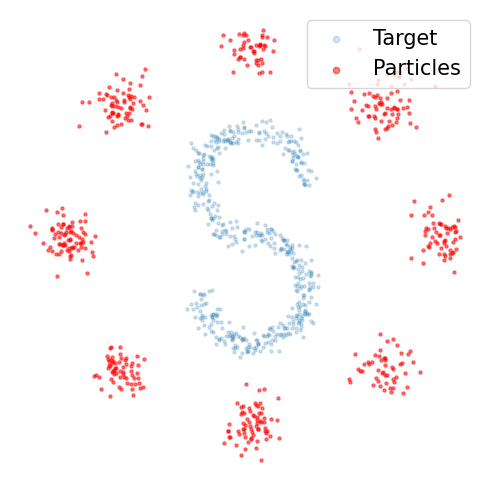

In [2]:
def make_moon_data(n_samples, noise=0.08):
    data, _ = datasets.make_moons(n_samples=n_samples, noise=noise) 
    data[:, 0] += -0.5
    return torch.tensor(data.astype("float32"))

def make_s_curve_data(n_samples, noise=0.12):
    data, _ = datasets.make_s_curve(n_samples=n_samples, noise=noise)
    data = data[:, [0, 2]] / 2.0
    return torch.tensor(data.astype("float32"))

def make_8gaussians(n_samples, scale=7, magnitude=0.25):
    # modified from https://github.com/wgrathwohl/LSD.git
    centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
    centers = [(scale * x, scale * y) for x, y in centers]

    dataset = []
    for i in range(n_samples):
        point = np.random.randn(2) * 0.5
        idx = np.random.randint(8)
        center = centers[idx]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype="float32")
    dataset *= magnitude
    return torch.tensor(dataset)


# choose the moon data or the s_curve data
#data = make_moon_data(n_samples=500)
data = make_s_curve_data(n_samples=512)
particles = make_8gaussians(n_samples=512)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.2, label=r'Target')
scatter_plot = ax.scatter(particles[:, 0], particles[:, 1], s=5, alpha=0.5, label=r'Particles', color='red')
ax.axis('equal')
ax.axis("off") # remove the axis will speed up the training
ax.legend(loc='upper right', fontsize=15, markerscale=2)
fig.tight_layout()
plt.show()

### 2. Building the model

In [3]:
# define a MLP discriminator
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=2):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 512)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        return self.fc3(x)

In [4]:
# build network
data_dim = 2
# loss
criterion = nn.BCEWithLogitsLoss()

D_logit = Discriminator().to(device)
xs = make_8gaussians(n_samples=512).to(device)
xs.requires_grad=True

# optimizer
D_optimizer = optim.Adam(D_logit.parameters(), lr = 0.001)

'''
One can also use SGD optimizer for xs which corresponds
to the standard forward Euler approach, but it works very slow.
'''
G_optimizer = optim.SGD([xs], lr = 0.001)
#G_optimizer = optim.Adam([xs], lr = 0.001)

def train_per_step(batch_size=512):
    D_losses, G_losses = [], []
    x = make_s_curve_data(batch_size).to(device)

    #==============Train the discriminator===============#
    D_optimizer.zero_grad()
    # train discriminator on p
    x_real, y_real = x.view(-1, data_dim), torch.ones(batch_size, 1).to(device)
    real_loss = criterion(D_logit(x_real), y_real)

    # train discriminator on q_i
    idx = np.random.choice(xs.shape[0], batch_size, replace=False)
    x_fake, y_fake = xs[idx], torch.zeros(batch_size, 1).to(device)
    fake_loss = criterion(D_logit(x_fake), y_fake)

    # gradient backprop & optimize ONLY D's parameters
    D_loss = real_loss + fake_loss
    D_loss.backward()
    D_optimizer.step()

    #==============Update particles===============#
    G_optimizer.zero_grad()
    
    # update all particles
    # batch gradient for each particle
    ''' torch.sum(logit_xs) is the sum for all log ratios,
            back-propogating the sum returns the gradient for each particle.
    '''
    G_loss = -torch.sum(D_logit(xs))
    G_loss.backward()
    G_optimizer.step()

    D_losses.append(D_loss.data.item())
    G_losses.append(G_loss.data.item())
    return torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))

### 3. Simulation of the ODE

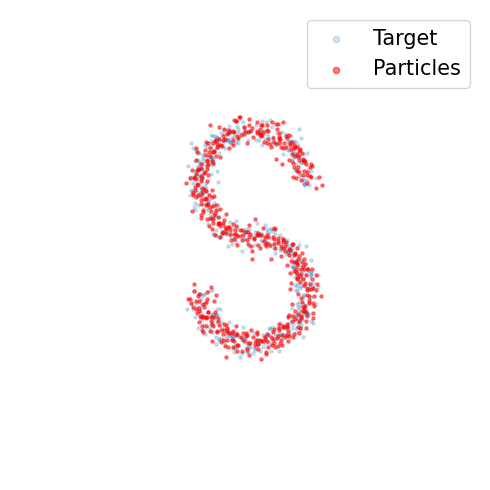

[2499/2500]: loss_d: 1.387, loss_g: -0.111, D_lr: 0.000607, G_lr: 0.000607


In [5]:
n_iters = 2500
scheduler_G = torch.optim.lr_scheduler.ExponentialLR(optimizer=G_optimizer, gamma=0.9998)
scheduler_D = torch.optim.lr_scheduler.ExponentialLR(optimizer=D_optimizer, gamma=0.9998)
flows = [xs.cpu().detach()]
clear_output(wait=True)
scatter_plot.set_offsets(xs.cpu().detach())

for k in range(0, n_iters):
    D_loss, G_loss = train_per_step()
    particles_t = xs.cpu().detach()
    scatter_plot.set_offsets(particles_t)
    flows.append(particles_t)
    clear_output(wait=True)
    display(fig)
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f, D_lr: %.6f, G_lr: %.6f' % (
            k, n_iters, D_loss, G_loss, scheduler_D.get_last_lr()[0], scheduler_G.get_last_lr()[0]))
    scheduler_G.step()
    scheduler_D.step()
flows = torch.stack(flows)
plt.close()

### 4. Generating animation

In [6]:
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import LineCollection
from tqdm import tqdm
 
ax.scatter(flows[0][:, 0], flows[0][:, 1], s=5, alpha=0.2, color='black', zorder=2)
lines = LineCollection([], lw=1.0, alpha=0.15, color='darkgrey', zorder=0)
ax.add_collection(lines)

def update(frame):
    
    scatter_plot.set_offsets(flows[frame])
    lines.set_segments(flows[0:frame].permute(1,0,2))
    
## Generate gif 
ani = FuncAnimation(fig=fig, func=update, frames=tqdm(range(0, len(flows), 3)), interval=1)
writer = PillowWriter(fps=50)  
ani.save("s_sgd.gif", writer=writer)  


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 833/834 [03:37<00:00,  2.05it/s]